In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

from src.maze_generator import get_maze_mdp, create_mdp
from src.policies import EpsGreedyPolicy, SoftmaxPolicy, PolicyFromQ
from src.learning import QLearning, VI_Q
from src.utils import get_one_episode, plot_errors, plot_maze_path_q
from src.utils import plot_q, viz_path, plot_maze, plot_effect_parameter, plot_convergence

In [4]:
SEED = 0
np.random.seed(SEED)

## Generate Maze

Best path length: 43


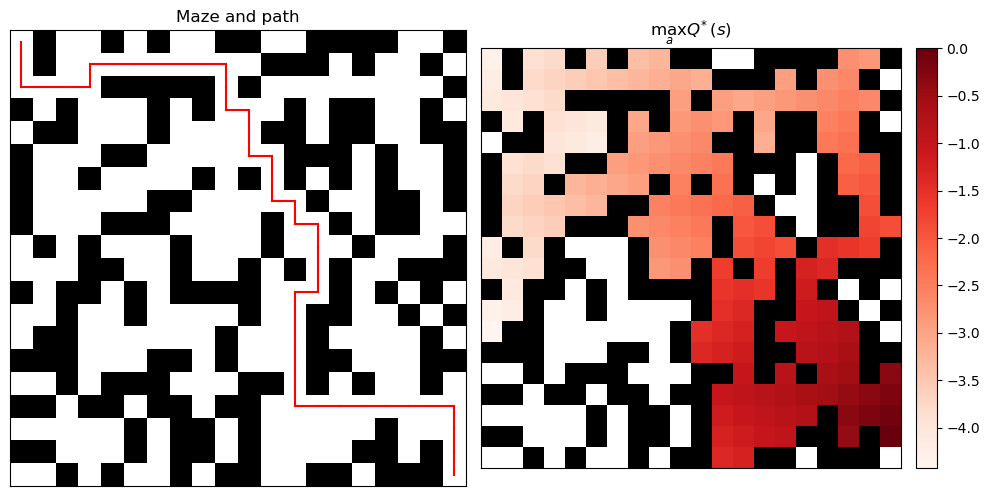

In [13]:
maze_name = "random large"
ALPHA = .6

if "random" in maze_name:
    if maze_name == "random small":
        nrows = 8
        ncols = 12
        p = .5
    elif maze_name == "random large":
        nrows = 20
        ncols = 20
        p = .4
    mdp, grid, qstar = get_maze_mdp(nrows, ncols, p, gamma=.9, seed=SEED)
elif "custom" in maze_name:
    if maze_name == "custom small":
        maze = np.load("custom_mazes/maze_14_14.npy")
    elif maze_name == "custom large":
        maze = np.load("custom_mazes/maze_29_29.npy")
    elif maze_name == "custom large bis":
        maze = np.load("custom_mazes/maze_29_29_bis.npy")
    else:
        raise ValueError("Unknown custom maze name")
    walls_ixs = np.where(maze.ravel() == 0)[0]
    mdp, grid = create_mdp(walls_ixs, *maze.shape, gamma=0.9)
    qstar, _ = VI_Q(mdp, eps=1e-8)
else:
    raise ValueError("Unknown maze name")

_, best_t, best_path = get_one_episode(mdp, qstar)

if "small" in maze_name:
    mdp.horizon = 1000
    NB_ITER = int(1e6)
elif "large" in maze_name:
    mdp.horizon = 10000
    NB_ITER = int(5*1e6)
else:
    raise ValueError("Unknown maze name")
PATIENCE = NB_ITER//20

print("Best path length: {}".format(best_t))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_maze_path_q(grid, qstar, best_path, axes=(ax1, ax2))
fig.tight_layout()

## Experiments

- Compare eps-greedy policy and softmax behaviour policy.
- Compare different values of the exploration parameters (epsilon for eps-greedy and tau for softmax).
- Compare different learning rates.
- Compare different sizes and difficluties of Maze MDPs.
- Check that your learned Q functions make sense.

### Epsilon-greedy vs Softmax policies

In [14]:
pol_eps = EpsGreedyPolicy(mdp, epsilon=.9).get_action
qhat_eps, list_errors_eps = QLearning(mdp, pol_eps, qstar, best_t, patience=PATIENCE, alpha=ALPHA, nb_iter=NB_ITER)
_, t_eps, path_eps = get_one_episode(mdp, qhat_eps)

Start Q learning with EpsGreedyPolicy


  5%|████▌                                                                                   | 259846/5000000 [00:06<01:54, 41414.58it/s, min path=43]


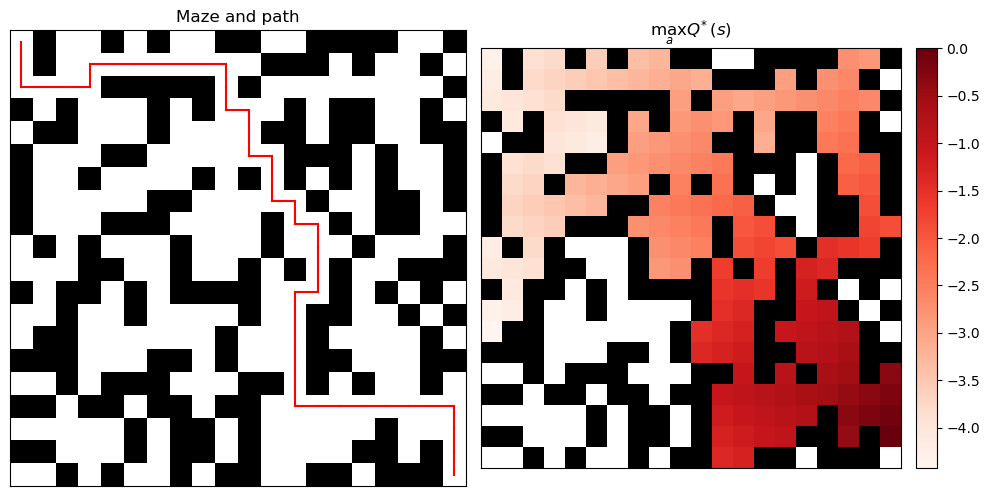

In [15]:
plot_maze_path_q(grid, qhat_eps, path_eps)
plt.tight_layout()

In [16]:
pol_soft = SoftmaxPolicy(mdp, tau=.9).get_action
qhat_soft, list_errors_soft = QLearning(mdp, pol_soft, qstar, best_t, patience=PATIENCE, alpha=ALPHA, nb_iter=NB_ITER)
_, t_soft, path_soft = get_one_episode(mdp, qhat_soft)

Start Q learning with SoftmaxPolicy


  4%|███▋                                                                                                 | 182918/5000000 [00:06<02:50, 28283.78it/s]


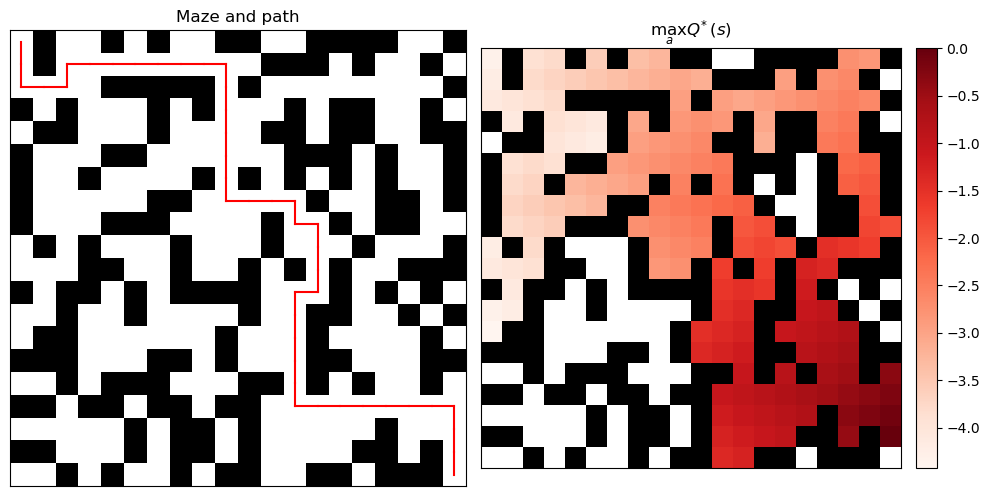

In [17]:
plot_maze_path_q(grid, qhat_soft, path_soft)
plt.tight_layout()

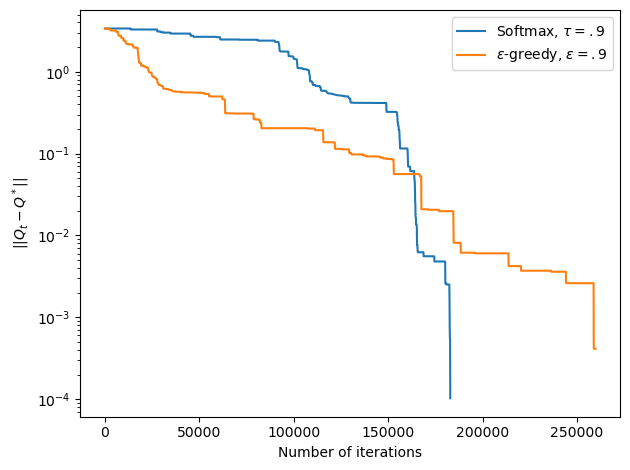

In [18]:
plot_errors({r"Softmax, $\tau = .9$": list_errors_soft, r"$\epsilon$-greedy, $\epsilon = .9$": list_errors_eps})
plt.tight_layout()

### Learning rates

Effect of the learning rate on the convergence (both policies). Average over 50 mazes. Other parameters are provided in the function parameters.

In [ ]:
N = 50
alpha = [.1, .3, .5, .7]
tau = 2
epsilon = .7
size_maze = 15
proportion_maze = .3
Horizon = 700

errors = np.zeros((len(alpha), int(1e6), N))

In [ ]:
for i, a in enumerate(alpha):
    for episode in range(N):
        maze_mdp, _, q_theory = get_maze_mdp(nrows=size_maze, ncols=size_maze, p=proportion_maze, Horizon=Horizon)

        pol_behaviour = EpsGreedyPolicy(maze_mdp, epsilon=epsilon).get_action
        q_maze, list_errors = QLearning(maze_mdp, pol_behaviour, alpha=a, nb_iter=int(1e6))
        errors[i, :, episode] = list_errors

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cmap = sns.color_palette()

for i, (a, err) in enumerate(zip(alpha, errors)):
    plot_convergence(err, name=r"$\alpha = {}$".format(a), color=cmap[i], ax=ax)

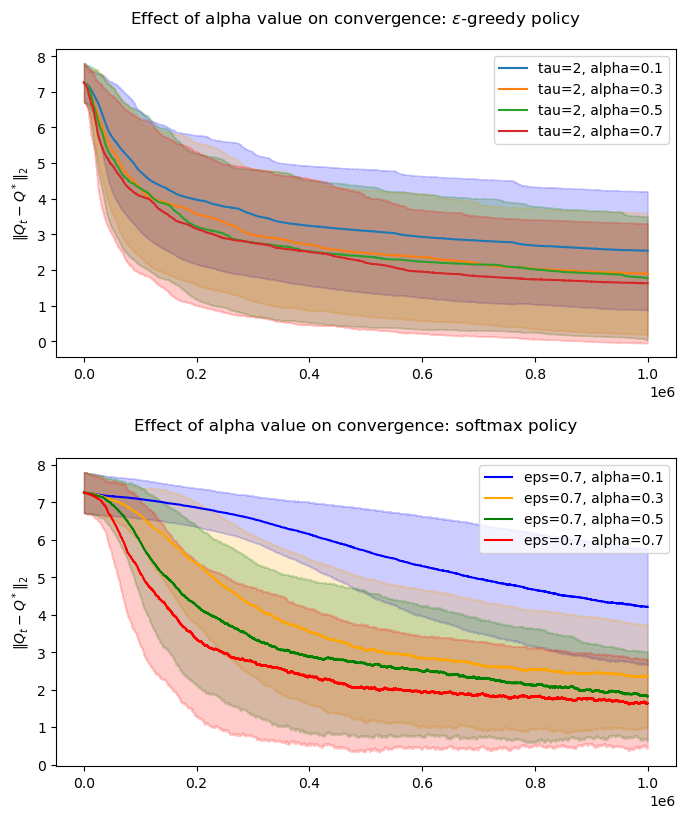

### Parameters of the policies

Effect of the epsilon on the success rate (Epsilon-greedy policy). Average over 50 mazes. Other parameters are provided in the function parameters.

In [ ]:
N = 50
epsilon = [.3, .5, .7, .9]
size_maze = 15
proportion_maze = .4
Horizon = 700
alpha = .5
policy_q_eval_maze = np.zeros((len(epsilon), N, 2))

for i, e in enumerate(epsilon):
    for episodes in range(N):
        maze_mdp, _, q_theory = get_maze_mdp(nrows=size_maze, ncols=size_maze, p=proportion_maze, Horizon=Horizon)

        pol_behaviour = EpsGreedyPolicy(maze_mdp, epsilon=e).get_action
        q_maze, errors = QLearning(maze_mdp, pol_behaviour, alpha=alpha, nb_iter=int(1e6))

        maze_mdp.reset()
        pol_q_maze = PolicyFromQ(maze_mdp, q_maze).get_action

        scores_episode, t_episode, path = maze_mdp.one_episode(pol_q_maze)
        policy_q_eval_maze[i, episodes, 0] = t_episode
        policy_q_eval_maze[i, episodes, 1] = scores_episode

In [ ]:
plot_effect_parameter(policy_q_eval_maze, epsilon, "epsilon")

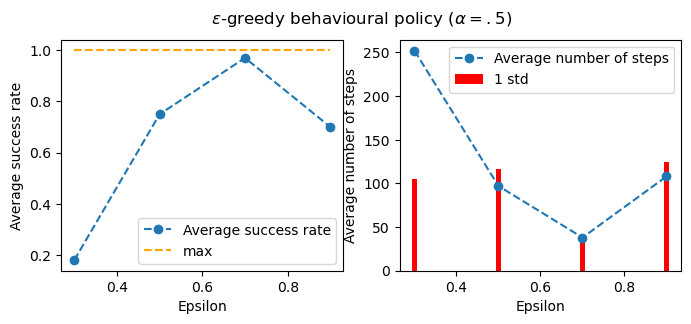

Effect of the tau on the success rate (Softmax policy). Average over 50 mazes. Other parameters are provided in the function parameters.

In [ ]:
N = 50
tau = [.5, 1, 2, 5]
size_maze = 15
proportion_maze = .4
Horizon = 700
alpha = .5
policy_q_eval_maze = np.zeros((len(tau), N, 2))

for i, t in enumerate(tau):
    for episodes in range(N):
        maze_mdp, _, q_theory = get_maze_mdp(nrows=size_maze, ncols=size_maze, p=proportion_maze, Horizon=Horizon)

        pol_behaviour = SoftmaxPolicy(maze_mdp, tau=t).get_action
        q_maze, errors = QLearning(maze_mdp, pol_behaviour, alpha=alpha, nb_iter=int(1e6))

        maze_mdp.reset()
        pol_q_maze = PolicyFromQ(maze_mdp, q_maze).get_action

        scores_episode, t_episode, path = maze_mdp.one_episode(pol_q_maze)
        policy_q_eval_maze[i, episodes, 0] = t_episode
        policy_q_eval_maze[i, episodes, 1] = scores_episode

In [ ]:
plot_effect_parameter(policy_q_eval_maze, tau, "tau")

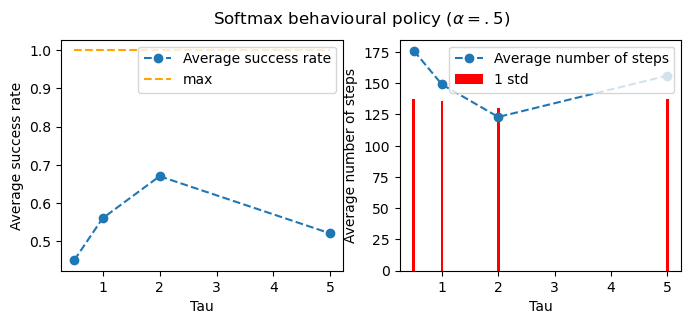

### Maze size and difficulty

In [19]:
conv1 = np.load("ckpts/conv_soft.npy")
path1 = np.load("ckpts/path_lens_soft.npy")

In [20]:
conv2 = np.load("ckpts/conv_eps.npy")
path2 = np.load("ckpts/path_lens_eps.npy")

In [21]:
sizes = [10, 20, 30]
probs = [.2, .3, .4]

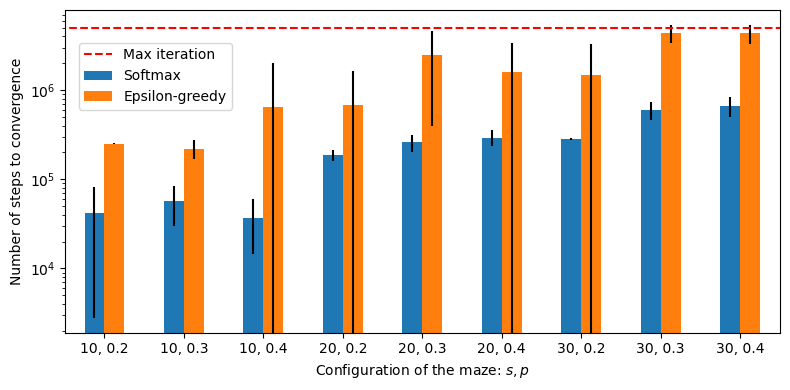

In [22]:
ss, pp = np.meshgrid(sizes, probs, indexing="ij")
s_p = iter(np.concatenate([ss.reshape(-1, 1).astype(int), pp.reshape(-1, 1)], axis=1))

# Assuming 'means' and 'std_devs' are your data
means1 = conv1.mean(axis=-1).ravel()
std_devs1 = conv1.std(axis=-1).ravel()
means2 = conv2.mean(axis=-1).ravel()
std_devs2 = conv2.std(axis=-1).ravel()
labels = [f"{s:.0f}, {p}" for (s, p) in s_p]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, means1, width, yerr=std_devs1, label='Softmax')
rects2 = ax.bar(x + width/2, means2, width, yerr=std_devs2, label='Epsilon-greedy')

ax.hlines(int(5e6), -1, len(labels), label="Max iteration", color="red", linestyles="dashed")

ax.set_xlim(x[0]-2*width, x[-1]+2*width)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r'Configuration of the maze: $s, p$')
ax.set_ylabel('Number of steps to convergence')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.92))

ax.set_yscale("log")

fig.tight_layout()
plt.savefig("ckpts/size_prob.png", dpi=300, bbox_inches="tight")

### Stochastic

In [23]:
errors = np.load("ckpts/errors.npy")

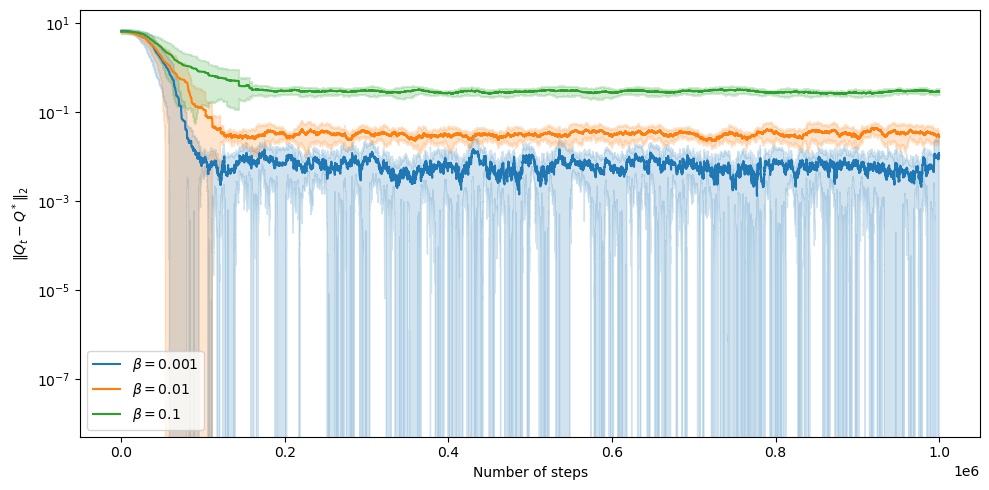

In [24]:
betas = [.001, .01, .1]
cmap = sns.color_palette()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, b in enumerate(betas):
    plot_convergence(errors[i], name=r"$\beta = {}$".format(b), color=cmap[i], ax=ax)

ax.set_yscale("log")
ax.legend()
fig.tight_layout()